# LeNet-5

Import statements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from tqdm import tqdm
import shutil
import ast

Dataframe creation

In [2]:
#Read both csv files into pandas dataframes
regularDataframe = pd.read_csv(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train.csv")
annotatedDataframe = pd.read_csv(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train_annotations.csv")

#Add PatientID column from the regular dataframe to the annotated dataframe
df = annotatedDataframe.merge(regularDataframe[['StudyInstanceUID', 'PatientID']], on='StudyInstanceUID', how='left')

#Convert string to list of lists in the column that represents the coordinates of the catheter outline
df['data'] = df['data'].apply(lambda x: ast.literal_eval(x))

#Drop all rows which are incompletely imaged NGTs or Swan Ganz catheters
df = df[~df['label'].isin(['NGT - Incompletely Imaged', 'Swan Ganz Catheter Present'])]

df.head()

,StudyInstanceUID,label,data,PatientID
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14...",ac2e8d106
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2...",ac2e8d106
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ...",35ac6438a
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,...",156d90dd4
4,1.2.826.0.1.3680043.8.498.87704688663091069148...,NGT - Normal,"[[1862, 14], [1845, 293], [1801, 869], [1716, ...",26da0d5ad


Train/test split on dataframe

In [4]:
#Retrieve all IDs of each unqiue image
unique_images = df['StudyInstanceUID'].unique()

#80/20 train test split on just the unique image IDs
train_ids, test_ids = train_test_split(
    unique_images,
    test_size=0.2,
    random_state=3,
    stratify=df.drop_duplicates('StudyInstanceUID')["label"]
)

#Create train and test dataframes with a mask that uses the image IDs found above
train_df = df[df['StudyInstanceUID'].isin(train_ids)]
test_df  = df[df['StudyInstanceUID'].isin(test_ids)]

Split image folder into train and test folders using exact same split as for the dataframe

In [8]:
#Paths to all images, and the train and test folders
all_images_dir = r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\all_images"
train_dir = r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train"
test_dir  = r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\test"

#Make sure that the train/test folders exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

#Function to move images from all_images to dest_dir, guided by the split that has been applied to the dataframe
def move_images(df, dest_dir):
    k=0
    for fname in tqdm(df["StudyInstanceUID"].unique(), desc=f"Moving to {os.path.basename(dest_dir)}"):
        src = os.path.join(all_images_dir, fname + ".jpg")
        dst = os.path.join(dest_dir, fname + ".jpg")
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            k+=1
    return k

#Apply the function to both the train and test images
print(f"Skipped {move_images(train_df, train_dir)} image IDs in train_df")
print(f"Skipped {move_images(test_df, test_dir)} image IDs in test_df")

Moving to train: 100%|██████████| 7254/7254 [01:05<00:00, 110.64it/s]


Skipped 0 image IDs in train_df


Moving to test: 100%|██████████| 1814/1814 [00:16<00:00, 112.33it/s]


Skipped 0 image IDs in test_df


Format x data by resizing images and putting into an array of length 7254 (train) and 1814 (test). Then, we normalise the pixel values and fix dimensions

In [16]:
x_train=[]

#Loop over all images IDs in the train folder
for fname in tqdm(os.listdir(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train")):
  #Retrieve the image based on its ID
  img = Image.open(rf"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train\{fname}")
  #Resize the image
  img = img.resize((32, 32), Image.Resampling.LANCZOS)
  #Add the image to our list
  x_train.append(img)


100%|██████████| 7254/7254 [01:36<00:00, 74.98it/s]


In [17]:
x_test=[]

#Loop over all images in test folder
for fname in tqdm(os.listdir(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\test")):
  #Retrieve the image based on its ID
  img = Image.open(rf"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\test\{fname}")
  #Resize the image
  img = img.resize((32, 32), Image.Resampling.LANCZOS)
  #Add the image to our list
  x_test.append(img)

100%|██████████| 1814/1814 [00:24<00:00, 74.75it/s]


In [18]:
#Convert PIL images to numpy arrays and normalize the pixel values
x_train = np.array([np.array(img, dtype=np.float32)/255.0 for img in x_train])
x_test  = np.array([np.array(img, dtype=np.float32)/255.0 for img in x_test])

#Add channel dimension so the conv2D layer in the model can work
x_train = np.expand_dims(x_train, axis=-1)  #shape is (7254, 32, 32, 1)
x_test = np.expand_dims(x_test, axis=-1)   #shape is (1814, 32, 32, 1)

Format y data by making an array of CVC, NGT or ETT labels that line up with the images in the x data exactly. Then, we convert y data from 'CVC', 'ETT', 'NGT' to 0,1,2, respectively.

In [20]:
#Create a dataframe which has only one row per image. This loses almost half of the rows and may create biases.
train_df_unique_images = train_df.drop_duplicates(subset=['StudyInstanceUID'])

y_train = []

#Loop over all image IDs in train folder
for fname in tqdm(os.listdir(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train")):
  #Retrieve the catheter type that corresponds to the image ID
  label = train_df_unique_images[train_df_unique_images["StudyInstanceUID"] == fname[:-4]].iloc[0,1][0:3]
  #Add the label to our list
  y_train.append(label)



100%|██████████| 7254/7254 [00:02<00:00, 2457.73it/s]


In [21]:
#Create a dataframe which has only one row per image. This loses almost half of the rows and may create biases.
test_df_unique_images = test_df.drop_duplicates(subset=['StudyInstanceUID'])

y_test = []

#Loop over all images in test folder
for fname in tqdm(os.listdir(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\test")):
  #Retrieve the catheter type that corresponds to the image ID
  label = test_df_unique_images[test_df_unique_images["StudyInstanceUID"] == fname[:-4]].iloc[0,1][0:3]
  #Add the label to our list
  y_test.append(label)

100%|██████████| 1814/1814 [00:00<00:00, 4901.19it/s]


In [22]:
#Instantiate the label encoder
le = LabelEncoder()

#Transform the strings to integers
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

A few checks to see if our x and y data is correctly formatted:

In [24]:
x_train.shape

(7254, 32, 32, 1)

In [25]:
y_train[0:5]

array([0, 2, 0, 0, 0], dtype=int64)

In [26]:
len(y_train)

7254

80/20 train/val split

In [28]:
#Set the validation size to 20% of the original train size
val_size = int(len(x_train)/5)

#Create validation splits 
x_val = x_train[-val_size:,:,:,:]
y_val = y_train[-val_size:]

#Cut down train data to exclude the validation splits
x_train = x_train[:-val_size,:,:,:]
y_train = y_train[:-val_size]


Instantiate the LeNet-5 model (can change a few of the parameters such as the activation function - use ReLU instead?)

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=x_train.shape[1:]))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(16, 5, activation='tanh'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(120, 5, activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()
#Sparse categorical corss entropy means one hot encoding of categories is not required
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy']) 

C:\Users\ethan\anaconda3\envs\ADS2002Project\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [32]:
history = model.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_val, y_val))

Epoch 1/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7112 - loss: 0.7806 - val_accuracy: 0.7041 - val_loss: 0.7622
Epoch 2/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7112 - loss: 0.7426 - val_accuracy: 0.7041 - val_loss: 0.7601
Epoch 3/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7112 - loss: 0.7448 - val_accuracy: 0.7041 - val_loss: 0.7553
Epoch 4/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7112 - loss: 0.7379 - val_accuracy: 0.7041 - val_loss: 0.7604
Epoch 5/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7112 - loss: 0.7418 - val_accuracy: 0.7041 - val_loss: 0.7548
Epoch 6/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7112 - loss: 0.7384 - val_accuracy: 0.7041 - val_loss: 0.7554
Epoch 7/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7112 - loss: 0.7372 - val_accuracy: 0.7041 - val_loss: 0.7544
Epoch 8/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7112 - loss: 0.7403 - val_accuracy: 0.7041 - val_loss:

Visually assess the model

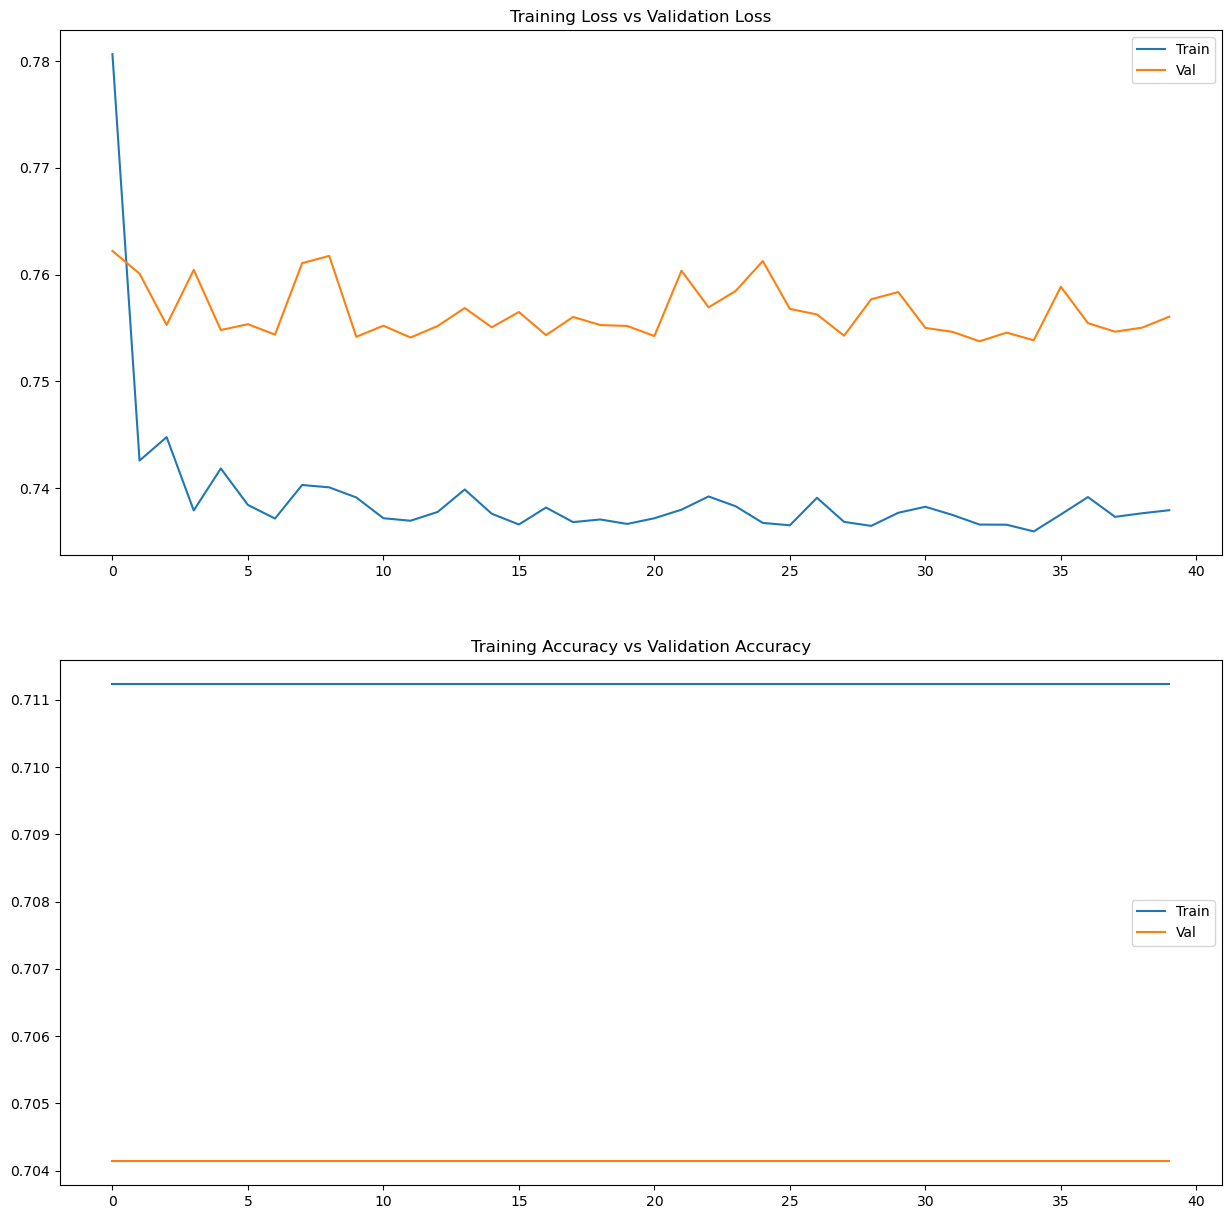

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

Numerically assess the model

In [36]:
model.evaluate(x_test, y_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7100 - loss: 0.7391


[0.7391481399536133, 0.7100330591201782]